In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torchdiffeq import odeint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import sys
sys.path.append('..')

from src.data.data_loader import MIMICDataset,import_data,collate_fn_padd
from src.data.data_scaler import PreProcess
from src.utils import setup_logger
from src.models.models import Baseline,NormalOutputNN,ODEGRU
from src.utils import seed_everything

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [2]:
df = import_data('../data/treatment_only_analysis.csv',verbose=False)

In [3]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'icu_admissiontime',
       'icu_dischargetime', 'timer', 'timer_dt', 'glc', 'glc_dt',
       'input_short_injection', 'input_short_push', 'input_intermediate',
       'input_long', 'starttime', 'endtime', 'input_hrs', 'infxstop', 'msk0',
       'msk'],
      dtype='object')

In [4]:
FEATURES = [ 'glc','input_short_injection', 
            'input_short_push', 'input_intermediate','input_long','input_hrs']
preproc = PreProcess(FEATURES,QuantileTransformer())
SEQUENCE_LEN = -1
preproc.fit(df)
#df = df.loc[~df.glc.isnull()].copy()
df = df.iloc[0:5000,:].copy()
df_preproc = preproc.transform(df)
df_preproc.loc[df_preproc.glc.isnull(),'glc'] = 999.
data_mimic = MIMICDataset(df_preproc,FEATURES,pad=SEQUENCE_LEN)

reconfiguring data...
excluded patients: 0
excluded rows: 0


In [5]:
df.loc[~df.glc.isnull()]

,subject_id,hadm_id,icustay_id,icu_admissiontime,icu_dischargetime,timer,timer_dt,glc,glc_dt,input_short_injection,input_short_push,input_intermediate,input_long,starttime,endtime,input_hrs,infxstop,msk0,msk
0,55973,152234,200001,0.0,73.88,2.88,20.78,118.0,72.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0,0
1,55973,152234,200001,0.0,73.88,20.78,26.88,72.0,135.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0,0
2,55973,152234,200001,0.0,73.88,26.88,36.88,135.0,106.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0,0
3,55973,152234,200001,0.0,73.88,36.88,44.88,106.0,125.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0,0
4,55973,152234,200001,0.0,73.88,44.88,50.88,125.0,101.0,0.0,0.0,0.0,0.0,NaN,NaN,0.000000,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999,52125,161239,201621,0.0,33.20,8.20,9.50,159.0,144.0,0.0,0.0,0.0,0.0,8.20,9.50,3.000000,0.0,0,0
5000,52125,161239,201621,0.0,33.20,9.50,10.55,144.0,139.0,0.0,0.0,0.0,0.0,9.50,10.55,4.001388,0.0,0,0
5001,52125,161239,201621,0.0,33.20,10.55,11.45,139.0,132.0,0.0,0.0,0.0,0.0,10.55,11.45,5.003550,0.0,0,0
5002,52125,161239,201621,0.0,33.20,11.45,12.50,132.0,107.0,0.0,0.0,0.0,0.0,11.45,13.45,6.006553,1.0,0,0


In [31]:
DT_SCALER = 1 / 24
SEQUENCE_LENGTH = 100
LAMBDA = 0.1

class NormalOutputNN(nn.Module):
    """
    Probabilistic outcome neural net
    - Normal distribution
    """
    def __init__(self,hidden_dim,device):
        super(NormalOutputNN, self).__init__()
        
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.Tanh(),
            nn.Linear(hidden_dim//2, 1)
        ).to(device)
        self.sigma_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.Tanh(),
            nn.Linear(hidden_dim//2, 1),
            nn.Softplus(),
        ).to(device)

    def forward(self, z):
        mu = self.mu_net(z)
        sigma = self.sigma_net(z)
        return (mu,sigma)

class LatentODE3_(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,hidden_dim,hidden_dim_input,hidden_dim_obs,batch_size,device):
        super(LatentODE3_, self).__init__()
        
        self.hidden_dim,self.hidden_dim_obs,self.hidden_dim_input = hidden_dim,hidden_dim_obs,hidden_dim_input
        #self.x = torch.zeros(batch_size,SEQUENCE_LENGTH,feature_dim).to(device)
        self.dt = torch.zeros(batch_size,SEQUENCE_LENGTH,1).to(device)
        self.device = device
        
        # dh/dt
        dh_dim = hidden_dim+hidden_dim_obs+hidden_dim_input
        self.dh = nn.Sequential(
            nn.Linear(dh_dim, max(50,dh_dim * 2)),
            nn.Tanh(),
            nn.Linear(max(50,dh_dim * 2), hidden_dim),
        )
        # dza/dt
        self.dz_a = nn.Sequential(
            nn.Linear(hidden_dim_input, max(hidden_dim_input * 2,50)),
            nn.Tanh(),
            nn.Linear(max(hidden_dim_input * 2,50), hidden_dim_input),
            nn.Tanh(),
        )
        # dzx/dt
        self.dz_x = nn.Sequential(
            nn.Linear(hidden_dim_obs, max(hidden_dim_obs * 2,50)),
            nn.Tanh(),
            nn.Linear(max(hidden_dim_obs * 2,50), hidden_dim_obs),
            nn.Tanh(),
        )
        

        # small weights to bound d/dt
        for m in self.dh.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        for m in self.dz_a.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        for m in self.dz_x.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        # dz/dt
        dh = self.dh(z)*(self.dt*DT_SCALER)
        dz_a = self.dz_a(z[:,:,self.hidden_dim:(self.hidden_dim+self.hidden_dim_input)])*(self.dt*DT_SCALER)
        dz_x = self.dz_x(z[:,:,(self.hidden_dim+self.hidden_dim_input):])*(self.dt*DT_SCALER)
        return torch.cat((dh,dz_a,dz_x),2)
    
    def solve_ode(self, z, t):
        #self.x = x  # overwrite
        self.dt = t
        outputs = odeint(self, z, torch.tensor([0,1.0]).to(self.device),rtol=1e-3,atol=1e-3)[1]
        return outputs

class LatentODE3(Baseline):

    def __init__(self, output_net,feature_dims,hidden_dims, p, output_dim, batch_size,device):
        Baseline.__init__(self, device)
        self.obs_dim,self.input_dim = feature_dims
        self.hidden_dim,self.hidden_dim_obs,self.hidden_dim_input = hidden_dims
        
        # continuous dynamics
        self.ODENet = LatentODE3_(self.hidden_dim,self.hidden_dim_input,self.hidden_dim_obs,batch_size,device).to(device)

        # discrete dynamics
        jumpNN_obs_dim = self.obs_dim+self.hidden_dim+self.hidden_dim_obs
        self.jumpNN_obs = nn.Sequential(
            nn.Linear(jumpNN_obs_dim, jumpNN_obs_dim),
            nn.Tanh(),
            nn.Linear(jumpNN_obs_dim, self.hidden_dim_obs)
        ).to(device)
        jumpNN_input_dim = self.input_dim+self.hidden_dim+self.hidden_dim_input
        self.jumpNN_input = nn.Sequential(
            nn.Linear(jumpNN_input_dim, jumpNN_input_dim),
            nn.Tanh(),
            nn.Linear(jumpNN_input_dim, self.hidden_dim_input)
        ).to(device)
        self.init_h = nn.Sequential(
            nn.Linear(self.obs_dim+self.input_dim, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim)
        ).to(device)


        # output net
        self.output_net = output_net(self.hidden_dim,device).to(device)

    def forward(self,dt,x,p=0.0,training=False):
        
        x_input = x[:,:,self.obs_dim:] 
        x = x[:,:,0:self.obs_dim] 
        
        # dimensions
        batch_size = x.size(0)
        T = x.size(1)
        
        # intialise empty outputs
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        sigma_out = torch.zeros(batch_size,T,1,device = self.device)
        mu0_out = torch.zeros(batch_size,T,1,device = self.device)
        sigma0_out = torch.zeros(batch_size,T,1,device = self.device)
        
        # intial states
        eps_init = 0.001
        #h_t = torch.zeros(batch_size,1,self.hidden_dim,device = self.device)
        za_t = torch.zeros(batch_size,1,self.hidden_dim_input,device = self.device)
        zx_t  = torch.zeros(batch_size,1,self.hidden_dim_obs,device = self.device)
        
        h_t = self.init_h(torch.cat((x[:,0:(1),:],x_input[:,0:(1),:]),2))
        
        # loop through data
        for i in range(0,T):
            # time gaps for this event
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            
            # jumps
            msk_x = x[:,i:(i+1),:] == 999.
            zx_t_new = self.jumpNN_obs(torch.cat((x[:,i:(i+1),:],zx_t,h_t),2))
            zx_t = zx_t_new*~msk_x + zx_t*msk_x
            msk_a = x_input[:,i:(i+1),:].sum(2) == 0.
            za_t_new = self.jumpNN_input(torch.cat((x_input[:,i:(i+1),:],za_t,h_t),2))
            za_t = za_t_new*~msk_a.unsqueeze(2) + za_t*msk_a.unsqueeze(2)
        
            # continuous dynamics
            z_all_t = torch.cat((h_t,za_t,zx_t),dim=2)
            z_all_t = self.ODENet.solve_ode(z_all_t,dt_i)
            h_t = z_all_t[:,:,0:self.hidden_dim]
            za_t = z_all_t[:,:,self.hidden_dim:(self.hidden_dim+self.hidden_dim_input)]
            zx_t = z_all_t[:,:,(self.hidden_dim+self.hidden_dim_input):]
            
            # output network
            mu_t,sigma_t = self.output_net(h_t)
            mu_out[:,i:(i+1),:] = mu_t
            sigma_out[:,i:(i+1),:] = sigma_t
            
        return (mu_out,sigma_out)
    
    def loss_fn(self,preds,y,y0,msk,msk0):
        # extract
        m_, s_ = preds
                
        # log probs
        # prediction
        distribution = torch.distributions.normal.Normal(m_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk].unsqueeze(1))
        
        llik = torch.sum(likelihood)
        return -llik
    
    def eval_fn(self,preds,y,msk):
        # extract
        m_, s_ = preds
                
        # log probs
        distribution = torch.distributions.normal.Normal(m_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk].unsqueeze(1))
        
        llik = torch.sum(likelihood)
        return -llik

In [32]:
model = LatentODE3(NormalOutputNN,(1,5),(8,4,4), 0.1, 1, 64, "cpu")

In [33]:
#model = ODEGRU(6, 8, 0.1, 1, 64,"cpu")

In [34]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

2992

In [35]:
dl_train = DataLoader(data_mimic,batch_size=64,collate_fn=collate_fn_padd)

In [36]:
model_optim = optim.RMSprop(model.parameters(), lr=1e-2)
NEPOCHS = 20
for epoch in range(0,NEPOCHS):
    model.train_single_epoch(dl_train,model_optim,verbose=False)

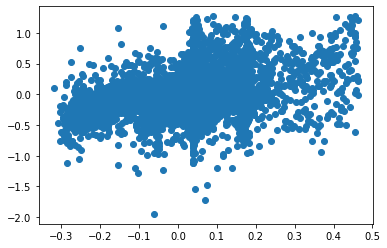

In [37]:
preds = model.predict(dl_train)
plt.scatter(preds[0],df_preproc.loc[df_preproc.msk==0].glc_dt)

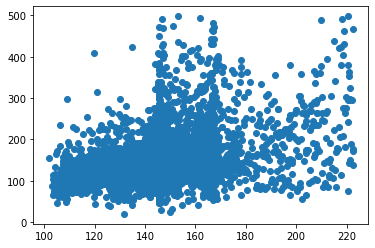

In [38]:
plt.scatter(ginv(preds[0]),ginv(df_preproc.loc[df_preproc.msk==0].glc_dt))

In [39]:
np.sqrt(np.mean((ginv(preds[0]) - ginv(df_preproc.loc[df_preproc.msk==0].glc_dt))**2))

59.15345713796856

In [40]:
np.sqrt(np.mean((ginv(df_preproc.loc[(df_preproc.msk==0) & (df_preproc.glc != 999.)].glc) - ginv(df_preproc.loc[(df_preproc.msk==0) & (df_preproc.glc != 999.)].glc_dt))**2))

44.85867747867749

(array([ 331.,  412.,  594., 1841.,  690.,  495.,   96.,   82.,   69.,
          60.]),
 array([101.774284, 113.84387 , 125.91345 , 137.98303 , 150.05261 ,
        162.12221 , 174.19179 , 186.26137 , 198.33096 , 210.40054 ,
        222.47012 ], dtype=float32),
 <BarContainer object of 10 artists>)

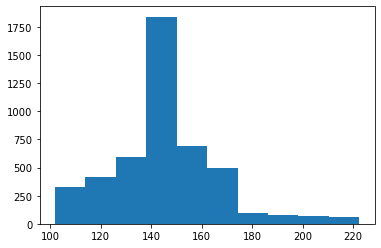

In [41]:
plt.hist(ginv(preds[0]))

(array([  88., 1243., 2009.,  729.,  302.,  143.,   57.,   56.,   28.,
          15.]),
 array([ 20. ,  67.8, 115.6, 163.4, 211.2, 259. , 306.8, 354.6, 402.4,
        450.2, 498. ]),
 <BarContainer object of 10 artists>)

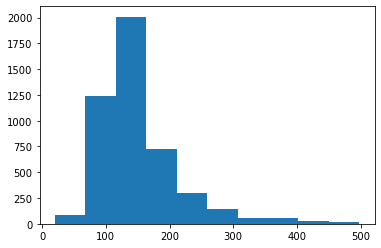

In [17]:
plt.hist(ginv(df_preproc.loc[df_preproc.msk==0].glc_dt))

(array([3.000e+00, 6.000e+00, 1.600e+01, 6.000e+01, 1.940e+02, 1.415e+03,
        2.771e+03, 1.750e+02, 2.800e+01, 2.000e+00]),
 array([-365.73945618, -306.81744843, -247.89544067, -188.97343292,
        -130.05142517,  -71.12941742,  -12.20740967,   46.71459808,
         105.63660583,  164.55861359,  223.48062134]),
 <BarContainer object of 10 artists>)

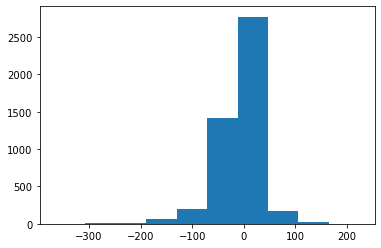

In [18]:
plt.hist(ginv(preds[0])-ginv(df_preproc.loc[df_preproc.msk==0].glc_dt))